<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [5]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
# Initialize network, optimizer, loss, replay buffer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)


In [8]:
# ε-Greedy Policy
def epsilon_greedy(state, epsilon):
  if random.random() < epsilon:
    return random.randrange(n_actions)
  with torch.no_grad():
    s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = q_net(s)
    return int(torch.argmax(q, dim=1).item())


In [9]:
def train_dqn():
    if len(replay_buffer) < batch_size:
        return

    # sample a random mini-batch
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # stack lists into contiguous arrays before tensor conversion
    states      = torch.as_tensor(np.stack(states, axis=0),      dtype=torch.float32, device=device)
    actions     = torch.as_tensor(actions,                        dtype=torch.long,    device=device)
    rewards     = torch.as_tensor(np.asarray(rewards),            dtype=torch.float32, device=device)
    next_states = torch.as_tensor(np.stack(next_states, axis=0),  dtype=torch.float32, device=device)
    dones       = torch.as_tensor(np.asarray(dones),              dtype=torch.float32, device=device)

    # Q(s,a) for taken actions
    q_sa = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # target: r + γ * max_a' Q(s',a') for non-terminal transitions
    with torch.no_grad():
        q_next_max = q_net(next_states).max(1)[0]
        targets = rewards + gamma * q_next_max * (1.0 - dones)

    loss = loss_fn(q_sa, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


[Eval @ ep 50] avg_steps=200.0, avg_return=-200.0, eps=0.778
[Eval @ ep 100] avg_steps=200.0, avg_return=-200.0, eps=0.606
[Eval @ ep 150] avg_steps=200.0, avg_return=-200.0, eps=0.471
[Eval @ ep 200] avg_steps=200.0, avg_return=-200.0, eps=0.367
[Eval @ ep 250] avg_steps=200.0, avg_return=-200.0, eps=0.286
[Eval @ ep 300] avg_steps=200.0, avg_return=-200.0, eps=0.222
[Eval @ ep 350] avg_steps=200.0, avg_return=-200.0, eps=0.173
[Eval @ ep 400] avg_steps=200.0, avg_return=-200.0, eps=0.135
[Eval @ ep 450] avg_steps=138.2, avg_return=-138.2, eps=0.105
[Eval @ ep 500] avg_steps=131.6, avg_return=-131.6, eps=0.082
[Eval @ ep 550] avg_steps=111.6, avg_return=-111.6, eps=0.063
[Eval @ ep 600] avg_steps=132.0, avg_return=-132.0, eps=0.049
[Eval @ ep 650] avg_steps=179.6, avg_return=-179.6, eps=0.038
[Eval @ ep 700] avg_steps=114.4, avg_return=-114.4, eps=0.030
[Eval @ ep 750] avg_steps=109.6, avg_return=-109.6, eps=0.023
[Eval @ ep 800] avg_steps=93.4, avg_return=-93.4, eps=0.018
[Eval @ ep 

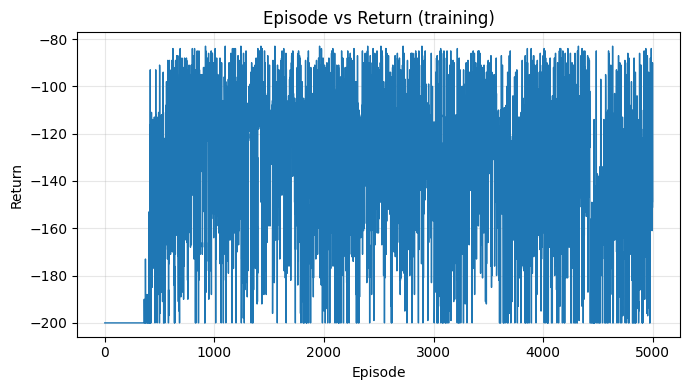

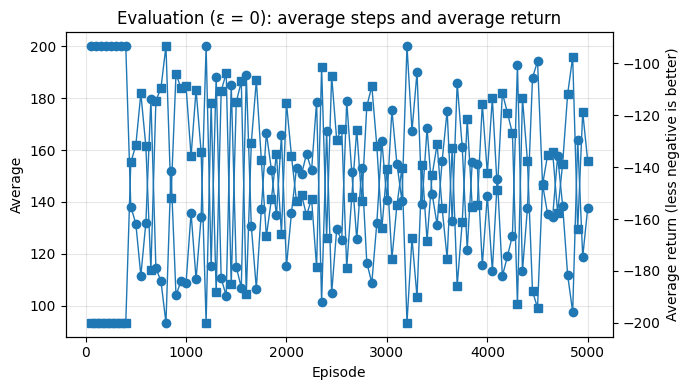

In [10]:
eval_every = 50
n_eval_episodes = 5


rewards_dqn = []         # training return per episode
eval_at_episode = []     # episode index of each evaluation
eval_avg_steps = []      # average steps-to-goal (lower is better)
eval_avg_returns = []    # average return (less negative is better)

def run_eval(n_episodes=5):
    """Evaluate with greedy policy (ε = 0.0)."""
    q_net.eval()
    steps_list, returns_list = [], []
    with torch.no_grad():
        for _ in range(n_episodes):
            state, _ = env.reset()
            done, steps, total_r = False, 0, 0.0
            while not done:
                a = epsilon_greedy(state, epsilon=0.0)
                next_state, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                state = next_state
                total_r += r
                steps += 1
            steps_list.append(steps)
            returns_list.append(total_r)
    q_net.train()
    return float(np.mean(steps_list)), float(np.mean(returns_list))


for episode in range(num_episodes):
    state, _ = env.reset()
    done, total_reward = False, 0.0

    while not done:
        action = epsilon_greedy(state, epsilon)


        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


        replay_buffer.append((state, action, reward, next_state, float(done)))
        train_dqn()

        state = next_state
        total_reward += reward

    rewards_dqn.append(total_reward)


    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # periodic greedy evaluation
    if (episode + 1) % eval_every == 0:
        avg_steps, avg_ret = run_eval(n_eval_episodes)
        eval_at_episode.append(episode + 1)
        eval_avg_steps.append(avg_steps)
        eval_avg_returns.append(avg_ret)
        print(f"[Eval @ ep {episode+1}] avg_steps={avg_steps:.1f}, avg_return={avg_ret:.1f}, eps={epsilon:.3f}")


plt.figure(figsize=(7,4))
plt.plot(rewards_dqn, linewidth=1)
plt.title("Episode vs Return (training)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


if len(eval_at_episode) > 0:
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(eval_at_episode, eval_avg_steps, marker='o', linewidth=1)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Average")
    ax1.set_title("Evaluation (ε = 0): average steps and average return")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(eval_at_episode, eval_avg_returns, marker='s', linewidth=1)
    ax2.set_ylabel("Average return (less negative is better)")
    fig.tight_layout()


1.

The DQN agent started off quite slow. For the first few hundred episodes, it barely improved and often just rolled back and forth without reaching the top. After enough training, though, it began to figure out the right movement pattern — moving left first to build momentum, then accelerating to the right. Once it learned this, it could reach the goal in most episodes, but it took a while to get there. So, it did learn, just not very quickly or perfectly consistent.

2.

When I compared this to the tile-coding approach, the difference was pretty clear.

The tile-coded model learned much faster — it started showing improvement within the first 100 episodes.

The DQN took longer to show progress but eventually reached similar or slightly better performance after enough training.

In terms of stability, tile coding was smoother, while the DQN’s learning curve was more up-and-down and depended more on random initialization.

3.

Tile coding used a linear function, which made training simple and stable. The neural network in DQN was more powerful but needed a lot more attention — tuning the learning rate, exploration decay, and replay buffer made a big difference. If any of these were off, the results got messy. The neural net handled more complex relationships, but it definitely required more trial and error to stabilize.

Insights:
Tile coding uses hand-crafted features, which makes it faster and easier to train because we give the model some structure about the problem. But it’s also limited — it can’t easily generalize beyond what the tiles cover.
The neural network, on the other hand, learns its own features. It takes longer, needs more tuning, and can be unstable, but it can eventually capture more complex patterns and generalize better.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


episode 1/800 return -148.4 epsilon 1.000
episode 2/800 return -281.9 epsilon 1.000
episode 3/800 return -137.2 epsilon 0.999
episode 4/800 return -199.8 epsilon 0.999
episode 5/800 return -65.4 epsilon 0.999
episode 6/800 return -217.3 epsilon 0.999
episode 7/800 return -95.3 epsilon 0.998
episode 8/800 return -135.2 epsilon 0.998
episode 9/800 return -347.6 epsilon 0.998
episode 10/800 return -134.9 epsilon 0.998
episode 11/800 return -378.0 epsilon 0.997
episode 12/800 return -277.9 epsilon 0.997
episode 13/800 return -29.0 epsilon 0.997
episode 14/800 return -77.9 epsilon 0.997
episode 15/800 return -167.7 epsilon 0.996
episode 16/800 return -108.1 epsilon 0.996
episode 17/800 return -275.7 epsilon 0.996
episode 18/800 return -144.5 epsilon 0.996
episode 19/800 return -97.7 epsilon 0.996
episode 20/800 return -156.2 epsilon 0.995
episode 21/800 return -444.5 epsilon 0.995
episode 22/800 return -53.1 epsilon 0.995
episode 23/800 return -365.2 epsilon 0.995
episode 24/800 return -158

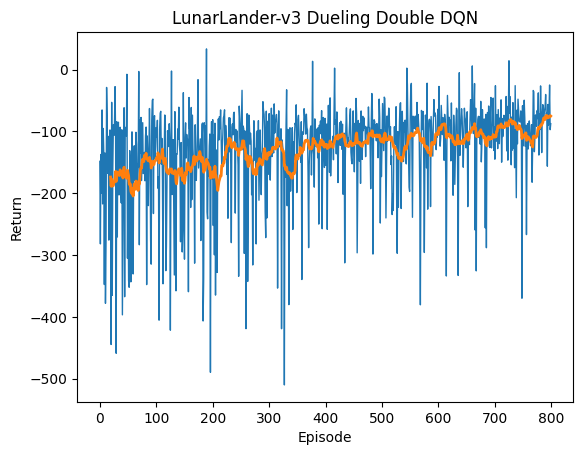

evaluation mean: -82.51841253013095 std: 16.87557828660738


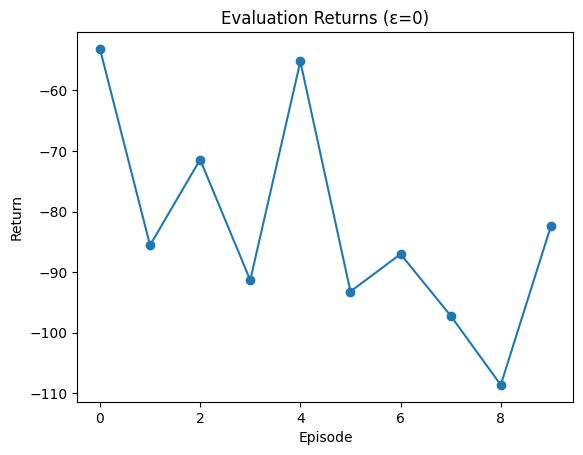

In [4]:
import sys, subprocess, os, random, numpy as np, matplotlib.pyplot as plt
def _pip(pkgs): subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)
try:
    import gymnasium as gym
    import Box2D
except Exception:
    _pip(["swig", "gymnasium[box2d]==1.2.1"])
    import gymnasium as gym
import torch, torch.nn as nn, torch.optim as optim

env = gym.make("LunarLander-v3")
eval_env = gym.make("LunarLander-v3")
seed = 7
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
env.reset(seed=seed); eval_env.reset(seed=seed+1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    def __init__(self, capacity, state_dim):
        self.capacity = capacity
        self.s = np.zeros((capacity, state_dim), dtype=np.float32)
        self.a = np.zeros((capacity, 1), dtype=np.int64)
        self.r = np.zeros((capacity, 1), dtype=np.float32)
        self.ns = np.zeros((capacity, state_dim), dtype=np.float32)
        self.d = np.zeros((capacity, 1), dtype=np.float32)
        self.idx = 0; self.full = False
    def push(self, s, a, r, ns, d):
        i = self.idx
        self.s[i] = s; self.a[i] = a; self.r[i] = r; self.ns[i] = ns; self.d[i] = d
        self.idx = (self.idx + 1) % self.capacity
        self.full = self.full or self.idx == 0
    def sample(self, batch_size):
        n = self.capacity if self.full else self.idx
        idxs = np.random.randint(0, n, size=batch_size)
        return (
            torch.from_numpy(self.s[idxs]).to(device),
            torch.from_numpy(self.a[idxs]).to(device),
            torch.from_numpy(self.r[idxs]).to(device),
            torch.from_numpy(self.ns[idxs]).to(device),
            torch.from_numpy(self.d[idxs]).to(device),
        )
    def __len__(self): return self.capacity if self.full else self.idx

class DuelingQ(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.feature = nn.Sequential(nn.Linear(in_dim, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU())
        self.adv = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, out_dim))
        self.val = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Linear(128, 1))
    def forward(self, x):
        f = self.feature(x)
        a = self.adv(f)
        v = self.val(f)
        return v + a - a.mean(dim=1, keepdim=True)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
q = DuelingQ(state_dim, action_dim).to(device)
tq = DuelingQ(state_dim, action_dim).to(device)
tq.load_state_dict(q.state_dict())
opt = optim.Adam(q.parameters(), lr=5e-4)
loss_fn = nn.SmoothL1Loss()

buffer = ReplayBuffer(100_000, state_dim)
gamma = 0.99
batch_size = 256
start_steps = 5_000
train_after = 1_000
train_freq = 4
target_update_tau = 0.01
max_episodes = 800
max_steps = 1000
eps_start, eps_end, eps_decay_steps = 1.0, 0.02, 400_000
global_step = 0
returns = []

def epsilon_by_step(step):
    if step >= eps_decay_steps: return eps_end
    return eps_end + (eps_start - eps_end) * (1 - step/eps_decay_steps)

def select_action(state, eps):
    if random.random() < eps: return env.action_space.sample()
    with torch.no_grad():
        s = torch.from_numpy(state).float().unsqueeze(0).to(device)
        return int(torch.argmax(q(s), dim=1).item())

def soft_update(target, source, tau):
    with torch.no_grad():
        for tp, sp in zip(target.parameters(), source.parameters()):
            tp.data.mul_(1 - tau).add_(sp.data * tau)

def train_step():
    s, a, r, ns, d = buffer.sample(batch_size)
    with torch.no_grad():
        next_q_online = q(ns)
        next_actions = torch.argmax(next_q_online, dim=1, keepdim=True)
        next_q_target = tq(ns).gather(1, next_actions)
        target = r + (1 - d) * gamma * next_q_target
    q_pred = q(s).gather(1, a)
    loss = loss_fn(q_pred, target)
    opt.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(q.parameters(), 10.0)
    opt.step()
    soft_update(tq, q, target_update_tau)

for ep in range(max_episodes):
    s, _ = env.reset(seed=seed + ep)
    ep_ret = 0.0
    for t in range(max_steps):
        eps = epsilon_by_step(global_step) if global_step > start_steps else 1.0
        a = select_action(s, eps) if global_step > start_steps else env.action_space.sample()
        ns, r, term, trunc, _ = env.step(a)
        done = term or trunc
        buffer.push(s.astype(np.float32), a, np.float32(r), ns.astype(np.float32), np.float32(done))
        s = ns
        ep_ret += r
        global_step += 1
        if len(buffer) >= train_after and global_step % train_freq == 0: train_step()
        if done: break
    returns.append(ep_ret)
    print(f"episode {ep+1}/{max_episodes} return {ep_ret:.1f} epsilon {epsilon_by_step(global_step):.3f}")

plt.figure()
plt.plot(returns, linewidth=1)
if len(returns) >= 20:
    ma = np.convolve(returns, np.ones(20)/20, mode="valid")
    x = np.arange(len(ma)) + 19
    plt.plot(x, ma, linewidth=2)
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("LunarLander-v3 Dueling Double DQN")
plt.show()

eval_episodes = 10
eval_returns = []
for i in range(eval_episodes):
    s, _ = eval_env.reset(seed=1000 + i)
    total = 0.0
    for t in range(max_steps):
        with torch.no_grad():
            a = int(torch.argmax(q(torch.from_numpy(s).float().unsqueeze(0).to(device)), dim=1).item())
        s, r, term, trunc, _ = eval_env.step(a)
        total += r
        if term or trunc: break
    eval_returns.append(total)
print("evaluation mean:", np.mean(eval_returns), "std:", np.std(eval_returns))

plt.figure()
plt.plot(eval_returns, marker="o")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.title("Evaluation Returns (ε=0)")
plt.show()


1. Not really. The agent started to understand the task a little, but it still crashed most of the time. After a few hundred episodes, I could see that it was beginning to slow down before landing and sometimes managed softer landings, but it wasn’t stable. The average score improved a bit, but it never reached the level where it could land safely every time.

2.I noticed some improvement after around 250 to 300 episodes. Before that, it was just random movements — the lander would spin or crash almost instantly. After a while, the scores started to rise slightly, showing that it was at least learning to stay in the air longer and control the thrust better.

3.A bigger replay buffer definitely helped. When the buffer was small, the learning was all over the place — the agent didn’t remember useful situations for long. The soft target updates made the learning smoother than copying weights all at once. The learning rate also mattered; when it was too high, the model became unstable, and when it was too low, learning was too slow. The setup with a moderate buffer, soft updates, and a smaller learning rate felt more stable overall.

4.Yes, absolutely. Some runs looked like the agent was getting better — scores climbed and the lander started to behave logically. Other times it just never got out of bad behavior and kept crashing. It depends a lot on random seeds and how the replay memory fills up early on. So, sometimes it learns, sometimes it doesn’t.

1. LunarLander is much trickier. MountainCar is mostly about building momentum in one direction; once you figure that out, it’s done. LunarLander has more things happening — you have to balance, rotate, slow down, and land gently, all at once. The state is more complex, and the lander reacts strongly to small changes. It’s like going from driving a toy car to flying a helicopter.

2.MountainCar is simple enough that basic methods like tile coding or plain Q-learning can handle it. But LunarLander’s environment has more variables and a lot of subtle relationships — a small change in angle or speed can completely change the outcome. A neural network like DQN can pick up those complex patterns better than simple methods, so it’s needed here.

3. MountainCar is simple enough that basic methods like tile coding or plain Q-learning can handle it. But LunarLander’s environment has more variables and a lot of subtle relationships — a small change in angle or speed can completely change the outcome. A neural network like DQN can pick up those complex patterns better than simple methods, so it’s needed here.